# Prac 08.1

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


/tmp/ipython-input-183186163.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


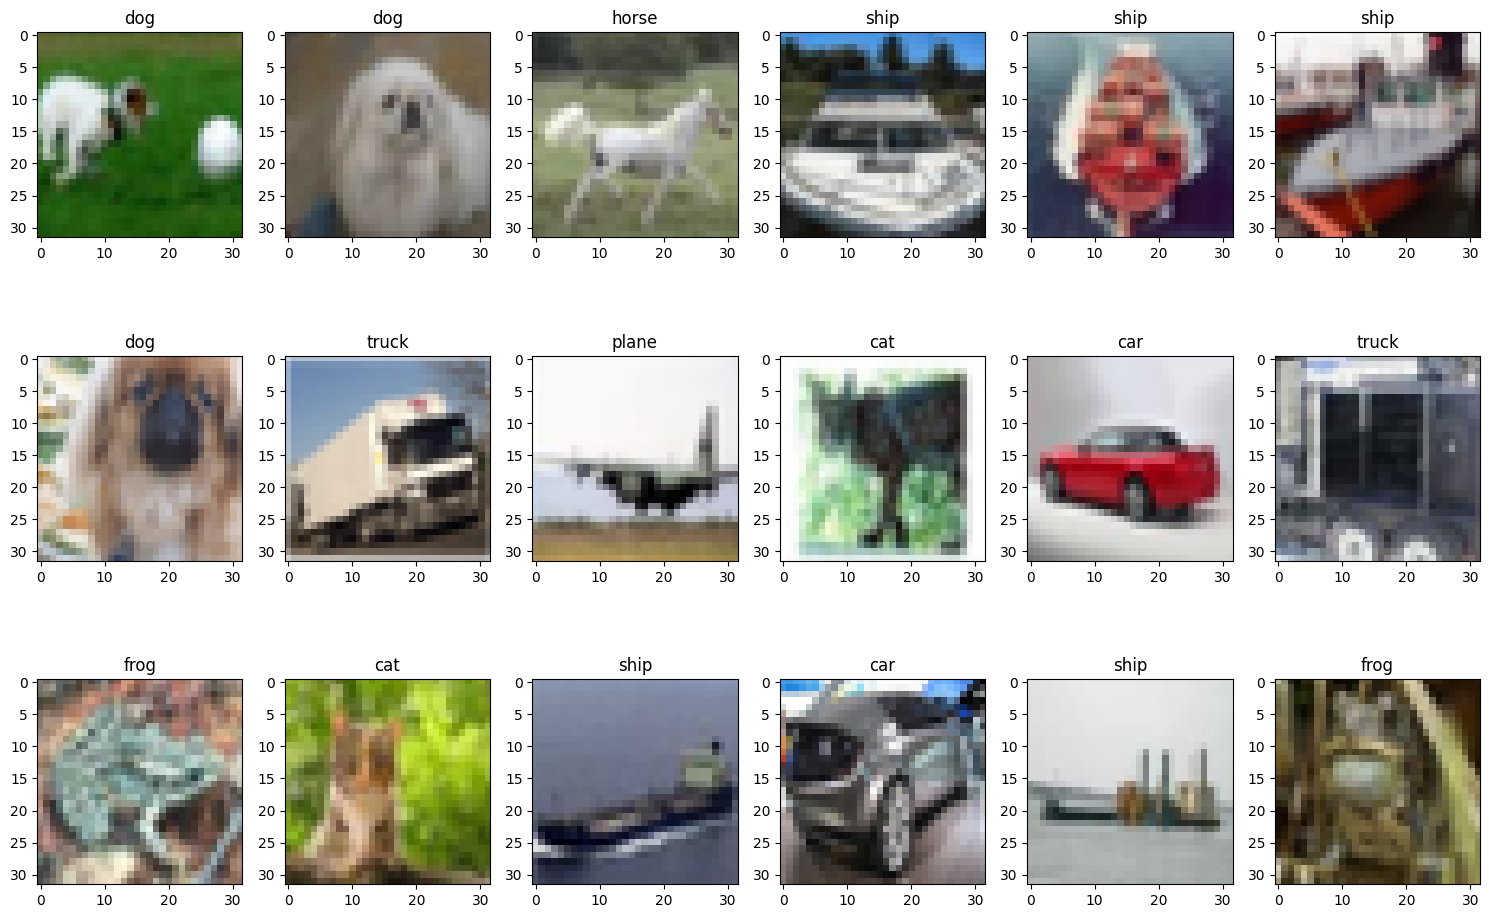

In [3]:
# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(0, x_train.shape[0])
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])
plt.tight_layout()
plt.show()

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

In [4]:
# Compute the class histogram
from collections import Counter

# Flatten labels to 1D
train_labels_flat = y_train.flatten()
hist = Counter(train_labels_flat)
print("Class histogram (train):")
for class_id, class_name in classes.items():
    print(class_name, ":", hist[class_id])

Class histogram (train):
plane : 5000
car : 5000
bird : 5000
cat : 5000
deer : 5000
dog : 5000
frog : 5000
horse : 5000
ship : 5000
truck : 5000


### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [5]:
# Normalization
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [6]:
# Build the classifier (простий CNN як для MNIST, але з 3 каналами й 10 класами)
inputs = Input(shape=(size, size, 3))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)

# Show the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,618 (64.91 KB)

 Trainable params: 16,618 (64.91 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training

Compile the model and train it.

In [7]:
epochs = 25
batch_size = 128

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Train the model
start = time()
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    verbose=1
)
print("Elapsed time:", time() - start)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2856 - loss: 1.9561 - val_accuracy: 0.4614 - val_loss: 1.5327
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4862 - loss: 1.4512 - val_accuracy: 0.5110 - val_loss: 1.3970
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5393 - loss: 1.3209 - val_accuracy: 0.5480 - val_loss: 1.2750
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5653 - loss: 1.2450 - val_accuracy: 0.5734 - val_loss: 1.2166
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5842 - loss: 1.1923 - val_accuracy: 0.5844 - val_loss: 1.1768
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5990 - loss: 1.1514 - val_accuracy: 0.6004 - val_loss: 1.1456
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6124 - loss: 1.1176 - val_accuracy: 0.6104 - val_loss: 1.1212
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6232 - loss: 1.0888 - val_accuracy: 0

Train Acc      0.700688898563385
Validation Acc 0.6557999849319458


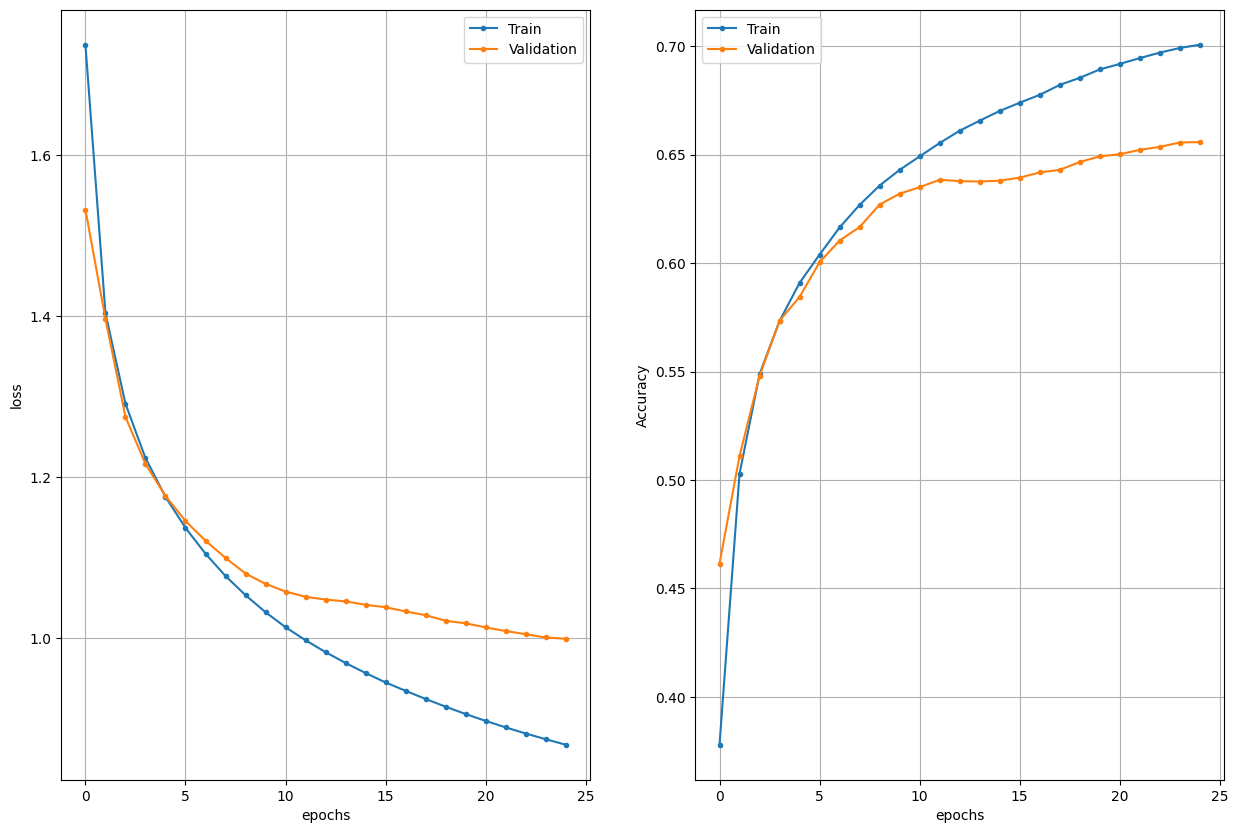

In [8]:
# Show training history
h = history.history
epochs_range = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs_range, h['loss'], '.-', epochs_range, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])

plt.subplot(122), plt.plot(epochs_range, h['accuracy'], '.-',
                           epochs_range, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])
plt.show()

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [9]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [10]:
# Compute and print the accuracy for each class
print("\nPer-class accuracy:")
for class_id, class_name in classes.items():
    mask = (y_true == class_id)
    acc = np.sum(y_pred[mask] == y_true[mask]) / np.sum(mask)
    print(class_name, acc)


Per-class accuracy:
plane 0.707
car 0.793
bird 0.495
cat 0.416
deer 0.673
dog 0.64
frog 0.769
horse 0.724
ship 0.612
truck 0.756


In [11]:
# Print the overall stats
ev = model.evaluate(x_test, y_test, verbose=0)
print('\nTest loss  ', ev[0])
print('Test metric (accuracy)', ev[1])


Test loss   1.0116515159606934
Test metric (accuracy) 0.6585000157356262


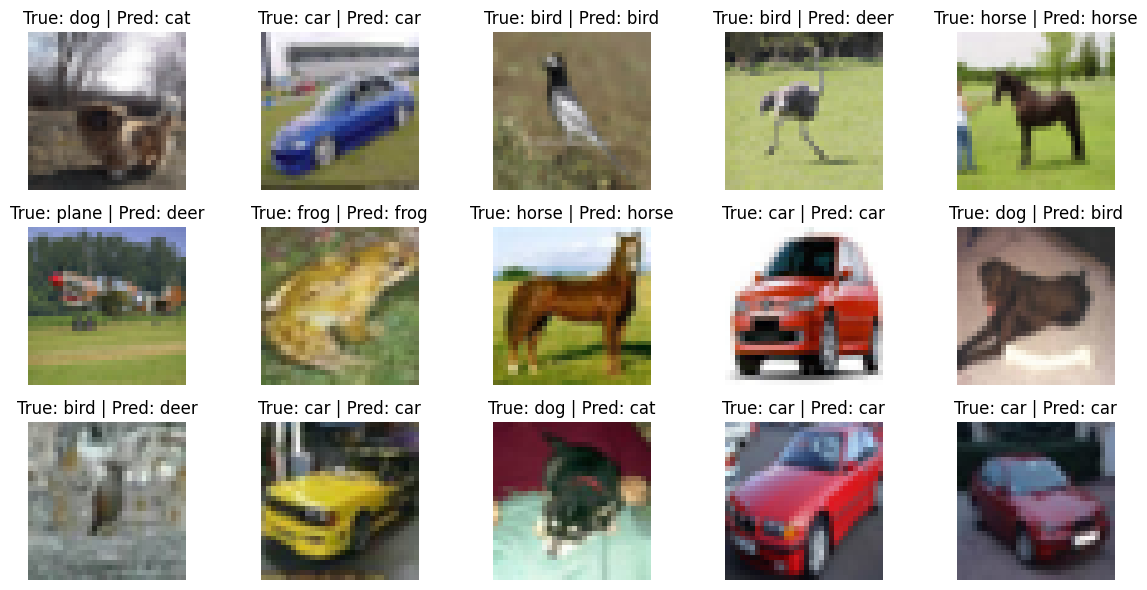

In [12]:
# Show random samples with predictions
plt.figure(figsize=(12, 6))
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, len(y_true))
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.axis('off')
    plt.title('True: ' + str(classes[y_true[idx]]) +
              ' | Pred: ' + str(classes[y_pred[idx]]))
plt.tight_layout()
plt.show()

### Questions

**• What is the overall accuracy of the classifier?**  
Базова модель досягла загальної тестової точності **приблизно 65.9%**.

**• What modifications would you do in order to improve the classification accuracy?**  
Я б збільшив глибину моделі, додав більше згорткових шарів та, за потреби, використав регуляризацію або аугментацію даних.

**• Make one modification (that you think can help) and train the classifier again.**


In [13]:
baseline_test_loss, baseline_test_acc = ev[0], ev[1]
print("\nBaseline model test accuracy:", baseline_test_acc)


Baseline model test accuracy: 0.6585000157356262


In [14]:
inputs_mod = Input(shape=(size, size, 3))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs_mod)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs_mod = Dense(num_classes, activation="softmax")(net)

model_mod = Model(inputs_mod, outputs_mod)

print("\nModified model summary:")
model_mod.summary()


Modified model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,154 (102.16 KB)

 Trainable params: 26,154 (102.16 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs_mod = 25
batch_size_mod = 128

model_mod.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

start = time()
history_mod = model_mod.fit(
    x_train, y_train,
    batch_size=batch_size_mod,
    epochs=epochs_mod,
    validation_split=0.1,
    verbose=1
)
print("Elapsed time (modified model):", time() - start)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2641 - loss: 1.9881 - val_accuracy: 0.4102 - val_loss: 1.6565
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4547 - loss: 1.5179 - val_accuracy: 0.4760 - val_loss: 1.4912
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5103 - loss: 1.3825 - val_accuracy: 0.5306 - val_loss: 1.3567
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5453 - loss: 1.2940 - val_accuracy: 0.5546 - val_loss: 1.2802
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5702 - loss: 1.2285 - val_accuracy: 0.5732 - val_loss: 1.2230
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5898 - loss: 1.1753 - val_accuracy: 0.5874 - val_loss: 1.1848
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6058 - loss: 1.1329 - val_accuracy: 0.6018 - val_loss: 1.1501
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6215 - loss: 1.0939 - val_accuracy: 0

Modified Train Acc      0.7307999730110168
Modified Validation Acc 0.680400013923645


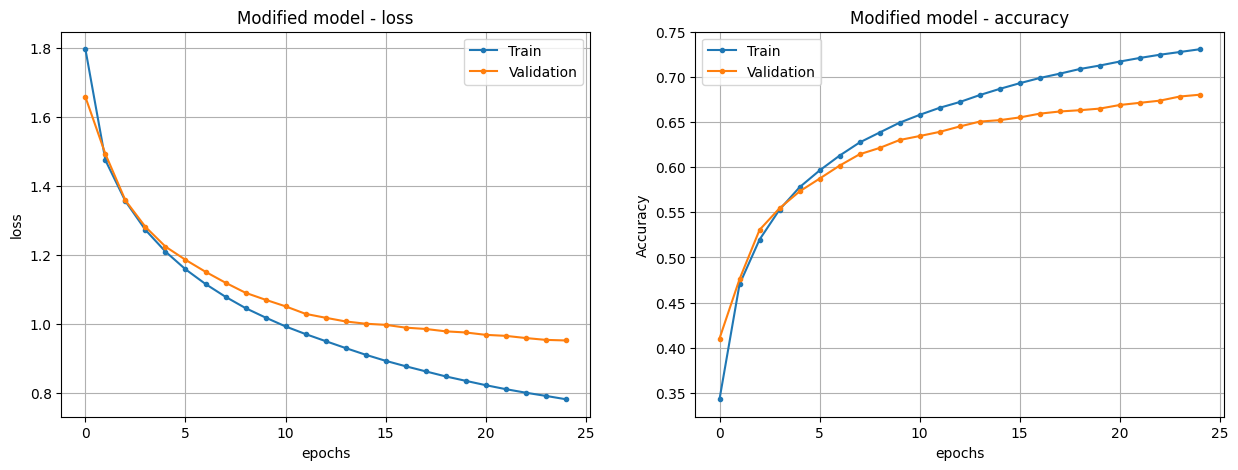

In [16]:
h2 = history_mod.history
epochs_range2 = range(len(h2['loss']))

plt.figure(figsize=(15, 5))
plt.subplot(121), plt.plot(epochs_range2, h2['loss'], '.-', epochs_range2, h2['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.title('Modified model - loss')

plt.subplot(122), plt.plot(epochs_range2, h2['accuracy'], '.-',
                           epochs_range2, h2['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Modified model - accuracy')

print('Modified Train Acc     ', h2['accuracy'][-1])
print('Modified Validation Acc', h2['val_accuracy'][-1])
plt.show()

In [17]:
ev_mod = model_mod.evaluate(x_test, y_test, verbose=0)
print('\nModified model - Test loss  ', ev_mod[0])
print('Modified model - Test accuracy', ev_mod[1])


Modified model - Test loss   0.9643893837928772
Modified model - Test accuracy 0.6730999946594238


**• Does the accuracy improve?**  
Після додавання ще одного блоку Conv2D + MaxPooling2D точність зросла з **65.9%** до **67.3%**.

# Prac 08.2

In this homework we will be working with the Fashion MNIST dataset. You will be given a classifier which suffers from considerable overfitting. Your objective will be to employ regularization techniques to mitigate the overfitting problem.

Let's start with the usual imports.

In [19]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Dataset

The MNIST fashgion dataset [link](https://github.com/zalandoresearch/fashion-mnist) was build by Zalando Reasearch tem consists of monochrome images of different type of clothing, namely:
* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

It is also one of the Keras built-in datasets. Let's load the images and quickly inspect it.

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Dataset params
num_classes = 10
size = x_train.shape[1]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


Let's visualise some random samples.

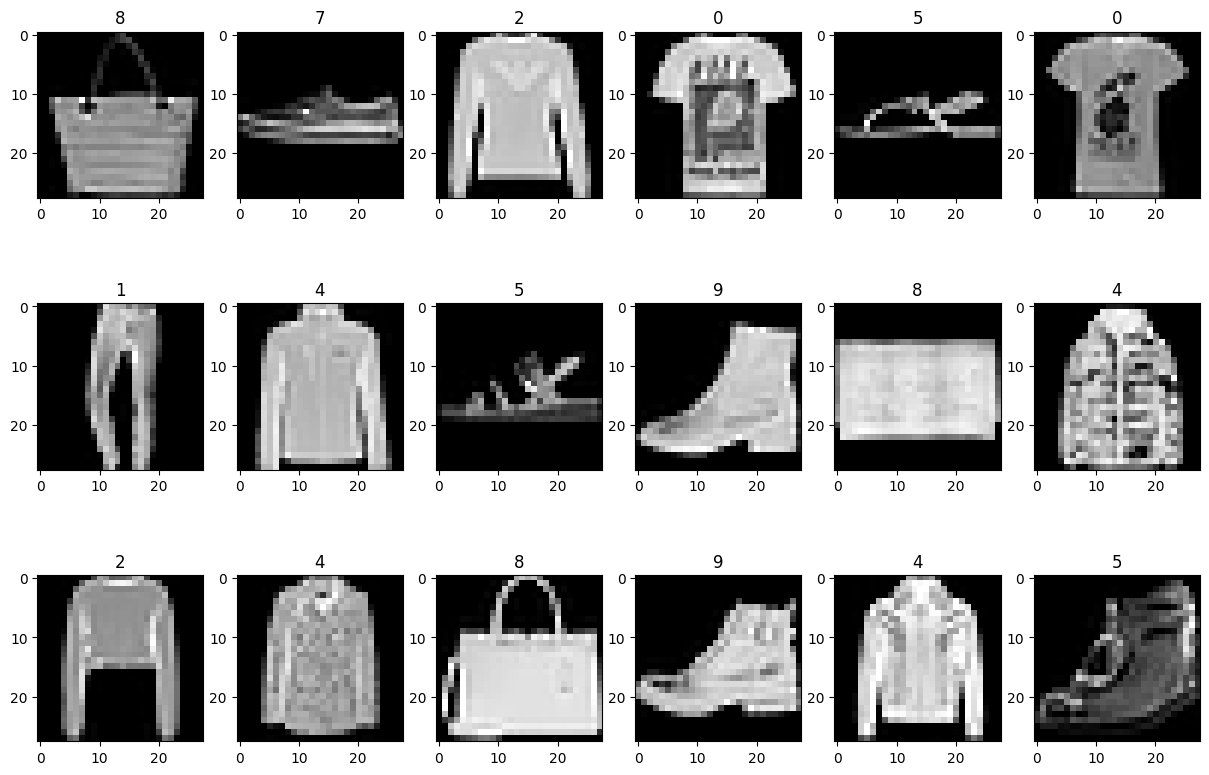

In [21]:
cnt = 1
for r in range(3):
    for c in range(6):
        idx = np.random.randint(len(x_train))
        plt.subplot(3,6,cnt)
        plt.imshow(x_train[idx, ...], cmap='gray')
        plt.title(y_train[idx])
        cnt = cnt + 1

### Building the Classifier

We are now going to build the baseline classifier that you will use throughout this homework.

In [22]:
# Data normalization
x_train = x_train/255
x_test = x_test/255

In [23]:
inputs = Input(shape=(28, 28, 1))
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = Flatten()(net)
net = Dense(128)(net)
outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,213,002 (12.26 MB)

 Trainable params: 3,213,002 (12.26 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 50
batch_size = 64

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8178 - loss: 0.5449 - val_accuracy: 0.8842 - val_loss: 0.3251
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9018 - loss: 0.2782 - val_accuracy: 0.8911 - val_loss: 0.3059
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9179 - loss: 0.2314 - val_accuracy: 0.8898 - val_loss: 0.3127
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9298 - loss: 0.1986 - val_accuracy: 0.8923 - val_loss: 0.3231
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9386 - loss: 0.1728 - val_accuracy: 0.8940 - val_loss: 0.3420
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9467 - loss: 0.1502 - val_accuracy: 0.8880 - val_loss: 0.3864
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9537 - loss: 0.1326 - val_accuracy: 0.8862 - val_loss: 0.4244
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9599 - loss: 0.1142 - val_accuracy: 0.

Train Acc      0.9939333200454712
Validation Acc 0.881600022315979


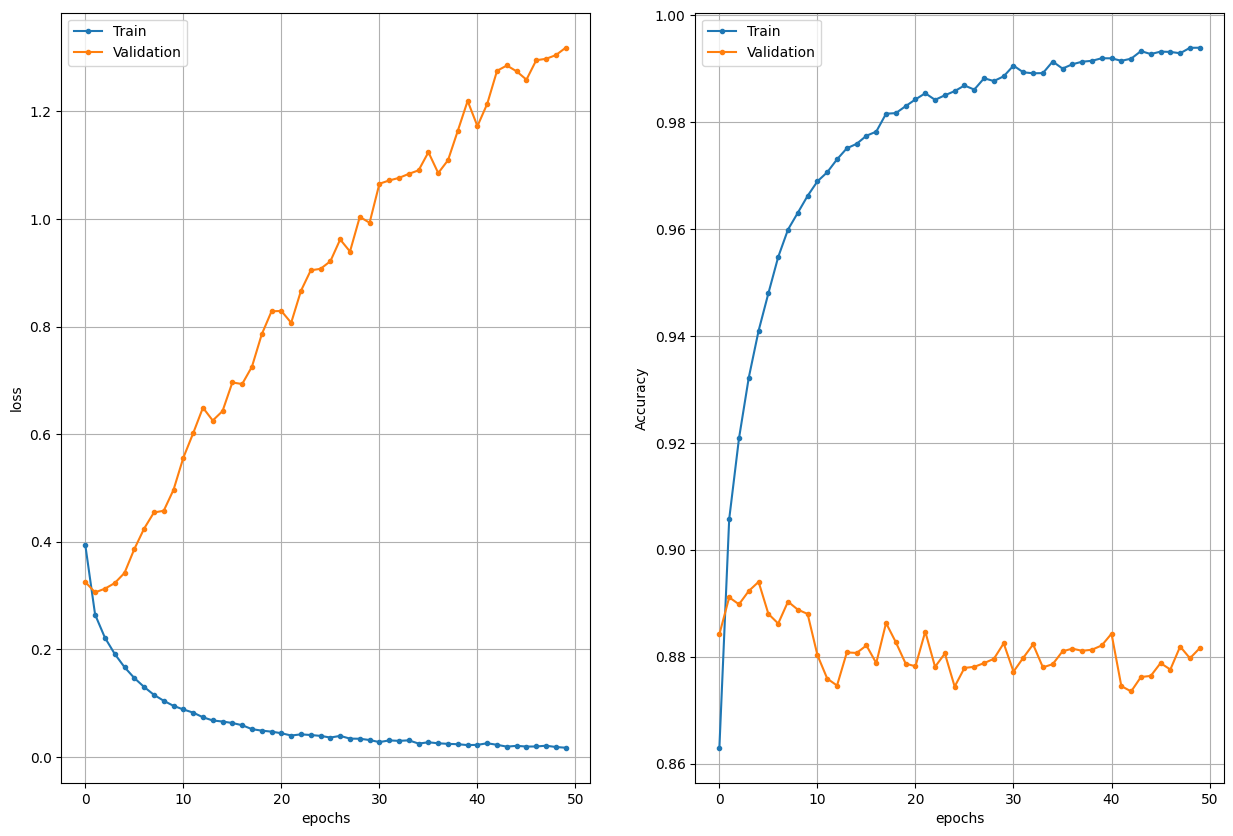

In [25]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

plot_history(history)

As you can see, the classifier suffers from massive overfitting. The validation accuracy is around 88% while the training accuracy is close to 1.

### Combat the Overfitting!

Now it is your turn. Use the classifier as a baseline, include some regularization techniques and try to improve the classification performance. You can try any techniques you might see fit, e.g.,
* Dropout
* Batch normalization
* Weight regularization
* Data augmentation
* Early stopping
* Pooling
* Reducing the number of parameters (the size of the network)
* ...

There are to objective you shall fulfill in order to successfully complete this homework:
* The validation accuracy shall be above 91%
* Your network (with all the regularizations applied) shall **not** be larger than the baseline

In [29]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust
x_train = x_train[..., np.newaxis]  # (N, 28, 28, 1)
x_test = x_test[..., np.newaxis]

inputs = Input(shape=(28, 28, 1))

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = BatchNormalization()(net)
net = Dropout(0.25)(net)

net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = BatchNormalization()(net)
net = Dropout(0.25)(net)

net = Flatten()(net)
net = Dense(
    64,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(1e-4)
)(net)
net = Dropout(0.5)(net)
outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)
print("\nRegularized model:")
model.summary()


Regularized model:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,618 (861.79 KB)

 Trainable params: 220,426 (861.04 KB)

 Non-trainable params: 192 (768.00 B)

In [30]:
# Train the network
epochs = 50
batch_size = 64

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

start = time()
history_reg = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1
)
print("Elapsed time (regularized model):", time() - start)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7325 - loss: 0.7826 - val_accuracy: 0.8729 - val_loss: 0.3673
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8490 - loss: 0.4390 - val_accuracy: 0.8886 - val_loss: 0.3437
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8645 - loss: 0.3946 - val_accuracy: 0.8929 - val_loss: 0.3394
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8730 - loss: 0.3778 - val_accuracy: 0.8950 - val_loss: 0.3215
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8839 - loss: 0.3559 - val_accuracy: 0.9007 - val_loss: 0.3284
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8876 - loss: 0.3481 - val_accuracy: 0.9008 - val_loss: 0.3237
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8914 - loss: 0.3439 - val_accuracy: 0.9071 - val_loss: 0.3109
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8956 - loss: 0.3427 - val_accuracy: 

Train Acc      0.9243333339691162
Validation Acc 0.9168999791145325


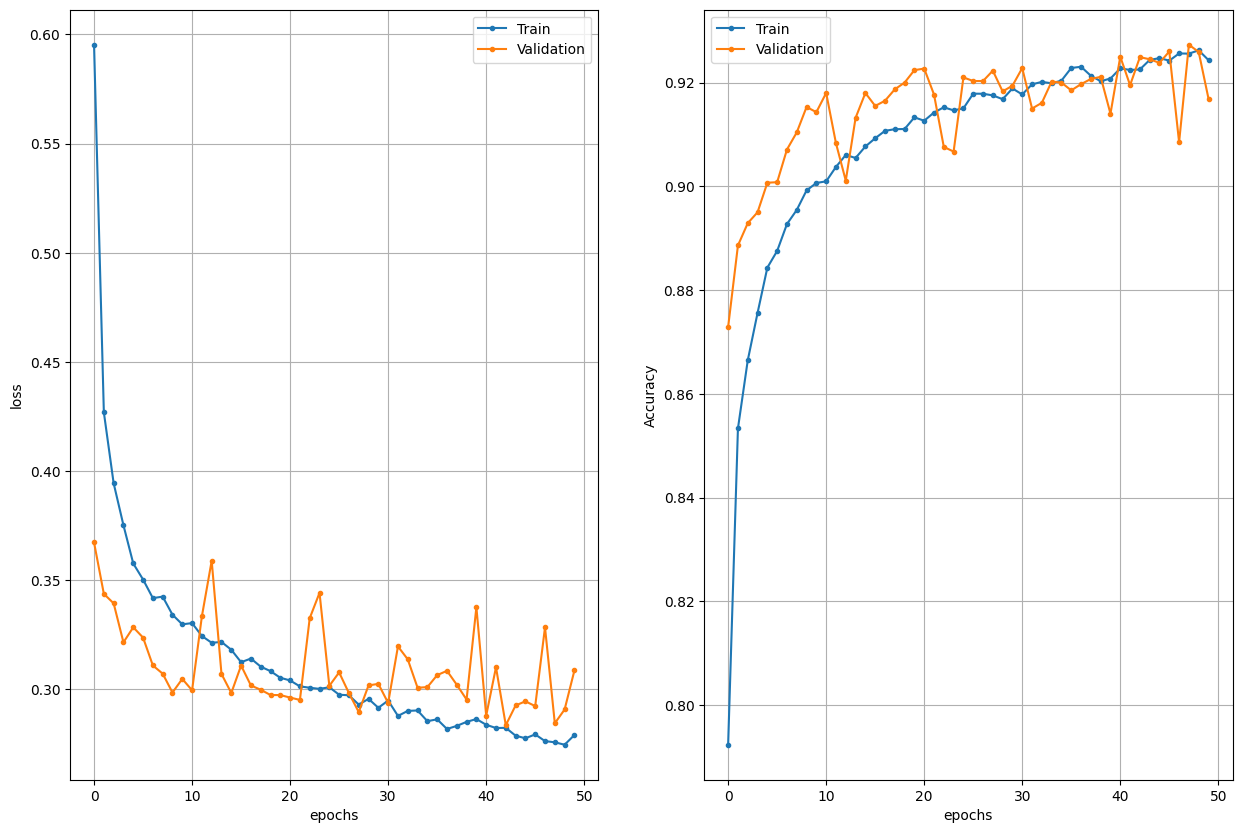

In [32]:
# Show the results
plot_history(history_reg)

In [33]:
reg_eval = model.evaluate(x_test, y_test, verbose=0)
print("Regularized model - Test loss:", reg_eval[0])
print("Regularized model - Test accuracy:", reg_eval[1])

print("Baseline test accuracy:   ", baseline_test_acc)
print("Regularized test accuracy:", reg_eval[1])

Regularized model - Test loss: 0.3086436986923218
Regularized model - Test accuracy: 0.9168999791145325
Baseline test accuracy:    0.6585000157356262
Regularized test accuracy: 0.9168999791145325


### Questions

**• What have you done in order to improve the performance?**  
Додав Dropout, BatchNorm, MaxPooling і зменшив Dense-шар, що зменшило перенавчання та підвищило точність.

**• Have you tried configurations that did not work out?**  
Так, моделі без пулінгу або з меншим Dropout усе ще переобучалися і не давали достатньої validation accuracy.
